# Tree of Thoughts

https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/tot/tot.ipynb

[Tree of Thoughts](https://arxiv.org/abs/2305.10601) (ToT), by Yao, et. al, is a general LLM agent search algorithm that combines reflection/evaluation and simple search (in this case BFS, though you can apply DFS or other algorithms if you'd like).

It has three main steps:

1. **Expand**: generate 1 or more candidate solutions to the problem.
2. **Score**: measure the quality of the responses.
3. **Prune**: retain the top K best candidates

Then return to "Expand" if no solution is found (or if the solution is of insufficient quality).

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## Task Definition

Our agent will try to play the "Game of 24". Given 4 numbers, it must generate a math equation that uses each of these numbers exactly one time to evaluate to a value of `24`.

In [2]:
import operator
from typing import List, Literal, Union, NamedTuple, Optional
from pydantic import BaseModel, Field

OperatorType = Literal["+", "-", "*", "/"]
TokenType = Union[float, OperatorType]

## We use these schemas to prompt the LLM to generate equations that evaluate to 24.


class Equation(BaseModel):
    """The formula combining the provided numbers to reach the target of 24."""

    tokens: List[TokenType] = Field(
        description="The stack of tokens and operators in reverse-polish notation. Example: [3, 4, '+', -1, '*'] would evaluate to (3 + 4) * -1 = -7.",
    )

    def compute(self) -> float:
        op_funcs = {
            "+": operator.add,
            "-": operator.sub,
            "*": operator.mul,
            "/": operator.truediv,
        }
        stack = []
        for token in self.tokens:
            if isinstance(token, float):
                stack.append(token)
            else:
                b, a = stack.pop(), stack.pop()
                stack.append(op_funcs[token](a, b))

        return stack[0]


class GuessEquations(BaseModel):
    """Submit multiple equations as guesses."""

    reasoning: str = Field(
        description="The reasoning behind the submitted guesses. Explain how you arrived at these equations."
    )

    equations: List[Equation] = Field(
        description="The list of equations to submit as guesses."
    )


## These objects will represent a single "candidate" (or scored candidate) within our agent's state.
# You can update the candidate object to match your own task.


class Candidate(NamedTuple):
    candidate: Equation
    score: Optional[float] = None
    feedback: Optional[str] = None

    def __str__(self):
        try:
            computed = self.candidate.compute()
        except Exception as e:
            computed = f"Invalid equation: {self.candidate.tokens}; Error: {repr(e)}"

        return f"Equation({self.candidate.tokens}) = {computed} (Reward: {self.score})"


class ScoredCandidate(Candidate):
    candidate: Equation
    score: float
    feedback: str

#### Fetch data

We'll use an example from the [Game of 24](https://github.com/princeton-nlp/tree-of-thought-llm) dataset.

In [ ]:
import csv
from pathlib import Path

# Use path relative to project root
project_root = Path().resolve().parent.parent.parent
data_file = project_root / "data/24.csv"

with open(data_file, "r") as file:
    csv_data = file.read()
# Get just the Puzzles column (column index 1)
puzzles = [row[1].strip() for row in csv.reader(csv_data.splitlines()[1:])]

print(f"Example puzzles: {puzzles[:3]}")

Example puzzles: ['1 1 4 6', '1 1 11 11', '1 1 3 8']


## Expander

The "tree of thoughts" algorithm is relatively generic. The primary two task-specific components are the **expander** and the **scorer**.
The expander (the augmented LLM) tries to generate 1 or more solutions to the problem. On subsequent attempts, it is given a seed/candidate value from 
the previous search.

You can update this section to match your own task requirements. The expander can be arbitrarily complex. All that's required is that it accepts the problem and an optional previous attempt (or attempts) and returns a new result.

In [4]:
from langchain_openai import ChatOpenAI
from langchain_community.chat_models import QianfanChatEndpoint
llm = QianfanChatEndpoint(
    model="ERNIE-3.5-8K",
    temperature=0.2,
    timeout=30,
)
llm2 = ChatOpenAI(
    model="llama3.2",
    base_url="http://localhost:11434/v1",
)

In [5]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are playing the Game of 24. Using the provide numbers, create an equation that evaluates to 24.\n"
            "Submit exactly {k} guesses for this round.",
        ),
        ("user", "Solve the 24 game for these numbers: {problem}.{candidate}"),
    ],
).partial(candidate="")

bound_llm = llm.with_structured_output(GuessEquations)
solver = prompt | bound_llm

# Scorer

In this game, the scorer is easy. We need to assert two things:

1. The LLM has generated a valid equation using each number exactly one time.
2. The equation evaluates to 24.

You can update this function to match your own task requirements.

In [ ]:
import csv
from pathlib import Path

# Use path relative to project root
project_root = Path().resolve().parent.parent.parent
data_file = project_root / "data/24.csv"

# Read the CSV file and find the row that matches the game_id
with open(data_file, "r") as file:
    reader = csv.DictReader(file)
    for row in reader:
        if row["game_id"] == str(game_id):
            # Create the 4x6 grid
            grid = []
            for i in range(1, 5):
                grid.append(list(map(int, row[f"puzzle{i}"].split())))

            # Find the initial state (numbers that are already placed)
            initial_state = {(i, j) for i in range(4) for j in range(6) if grid[i][j] != 0}
            break
print(grid)
print(initial_state)

## Graph

Now it's time to create our graph.

In [7]:
import operator
from typing import Optional, Dict, Any
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph

from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.checkpoint.memory import MemorySaver


def update_candidates(
    existing: Optional[list] = None,
    updates: Optional[Union[list, Literal["clear"]]] = None,
) -> List[str]:
    if existing is None:
        existing = []
    if updates is None:
        return existing
    if updates == "clear":
        return []
    # Concatenate the lists
    return existing + updates


class ToTState(TypedDict):
    problem: str
    candidates: Annotated[List[Candidate], update_candidates]
    scored_candidates: Annotated[List[ScoredCandidate], update_candidates]
    depth: Annotated[int, operator.add]


class Configuration(TypedDict, total=False):
    max_depth: int
    threshold: float
    k: int
    beam_size: int


def _ensure_configurable(config: RunnableConfig) -> Configuration:
    """Get params that configure the search algorithm."""
    configurable = config.get("configurable", {})
    return {
        **configurable,
        "max_depth": configurable.get("max_depth", 10),
        "threshold": config.get("threshold", 0.9),
        "k": configurable.get("k", 5),
        "beam_size": configurable.get("beam_size", 3),
    }


class ExpansionState(ToTState):
    seed: Optional[Candidate]


def expand(state: ExpansionState, *, config: RunnableConfig) -> Dict[str, List[str]]:
    """Generate the next state."""
    configurable = _ensure_configurable(config)
    if not state.get("seed"):
        candidate_str = ""
    else:
        candidate_str = "\n\n" + str(state["seed"])
    try:
        equation_submission = solver.invoke(
            {
                "problem": state["problem"],
                "candidate": candidate_str,
                "k": configurable["k"],
            },
            config=config,
        )
    except Exception:
        return {"candidates": []}
    new_candidates = [
        Candidate(candidate=equation) for equation in equation_submission.equations
    ]
    return {"candidates": new_candidates}


def score(state: ToTState) -> Dict[str, List[float]]:
    """Evaluate the candidate generations."""
    candidates = state["candidates"]
    scored = []
    for candidate in candidates:
        scored.append(compute_score(state["problem"], candidate))
    return {"scored_candidates": scored, "candidates": "clear"}


def prune(
    state: ToTState, *, config: RunnableConfig
) -> Dict[str, List[Dict[str, Any]]]:
    scored_candidates = state["scored_candidates"]
    beam_size = _ensure_configurable(config)["beam_size"]
    organized = sorted(
        scored_candidates, key=lambda candidate: candidate[1], reverse=True
    )
    pruned = organized[:beam_size]
    return {
        # Update the starting point for the next iteration
        "candidates": pruned,
        # Clear the old memory
        "scored_candidates": "clear",
        # Increment the depth by 1
        "depth": 1,
    }


def should_terminate(
    state: ToTState, config: RunnableConfig
) -> Union[Literal["__end__"], Send]:
    configurable = _ensure_configurable(config)
    solved = state["candidates"][0].score >= configurable["threshold"]
    if solved or state["depth"] >= configurable["max_depth"]:
        return "__end__"
    return [
        Send("expand", {**state, "somevalseed": candidate})
        for candidate in state["candidates"]
    ]


# Create the graph
builder = StateGraph(state_schema=ToTState, config_schema=Configuration)

# Add nodes
builder.add_node(expand)
builder.add_node(score)
builder.add_node(prune)

# Add edges
builder.add_edge("expand", "score")
builder.add_edge("score", "prune")
builder.add_conditional_edges("prune", should_terminate, path_map=["expand", "__end__"])

# Set entry point
builder.add_edge("__start__", "expand")

# Compile the graph
graph = builder.compile(checkpointer=MemorySaver())

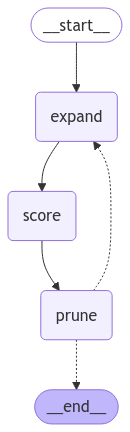

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Run

Now let's try it on one of the puzzles!

In [11]:
config = {
    "configurable": {
        "thread_id": "test_1",
        "depth": 5,
        "recursion_limit": 100
    }
}
for step in graph.stream({"problem": puzzles[42]}, config):
    print(step)

{'expand': {'candidates': [Candidate(candidate=Equation(tokens=[1.0, 5.0, 7.0, 12.0]), score=None, feedback=None)]}}


AttributeError: 'list' object has no attribute 'candidate'

In [ ]:
final_state = graph.get_state(config)
winning_solution = final_state.values["candidates"][0]
search_depth = final_state.values["depth"]
if winning_solution[1] == 1:
    print(f"Found a winning solution in {search_depth} steps: {winning_solution}")
else:
    print(
        f"Failed to find a winning solution in {search_depth} steps. Best guess: {winning_solution}"
    )